In [1]:
import os, pathlib, random, time, sys
import numpy as np
from scipy.ndimage import convolve
from osgeo import gdal
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_auc_score, accuracy_score,
                             classification_report, f1_score,precision_score, recall_score)
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import mixed_precision

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

tf.config.optimizer.set_jit(True)  # Enable XLA for acceleration
mixed_precision.set_global_policy("mixed_float16")   



c:\conda\envs\cuda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [2]:
# Configuration
ROOT        = pathlib.Path(".")
HH_PATH     = ROOT / "psdd_ap_hh_d0_2023_sub.tif"
HV_PATH     = ROOT / "hv.tif"
LAB_PATH    = ROOT / "psdd_ap_20230811_20230822_set5__sub.tif"
MODEL_DIR   = ROOT / "model_ranger_mask_window_4_stride_12"

PATCH       = 32
PAD         = 4
PATCH_EFF   = PATCH - 2*PAD
WINDOW      = 4
STRIDE_S    = 12
STRIDE_T    = 1
NEG_RATIO   = 6

BATCH_TRAIN = 70
BATCH_PRED  = 64
EPOCHS      = 30
TILE        = 512
THR_GRID    = np.linspace(0.25, 0.65, 41)


In [3]:
#file reading
ds_hh  = gdal.Open(str(HH_PATH),  gdal.GA_ReadOnly)
ds_hv  = gdal.Open(str(HV_PATH),  gdal.GA_ReadOnly)
ds_lab = gdal.Open(str(LAB_PATH), gdal.GA_ReadOnly)

W, H = ds_hh.RasterXSize, ds_hh.RasterYSize
print(f"Scene size: {W} × {H}")

# tiling
tiles = [(x, y, min(TILE, W-x), min(TILE, H-y))
         for y in range(0, H, TILE)
         for x in range(0, W, TILE)]

# dataset splits
ids    = list(range(len(tiles)))
tr, te = np.split(np.random.RandomState(SEED).permutation(ids), [int(0.8*len(ids))])
tr, va = np.split(tr, [int(0.75*len(tr))])
split  = {"train": tr.tolist(), "val": va.tolist(), "test": te.tolist()}


Scene size: 6283 × 9768


In [4]:
def read_sar_tile(ds, x, y, w, h, bands, pad):
    # Read specified bands from raster at (x,y,w,h) and return padded tile and NaN mask
    arr = np.stack([ds.GetRasterBand(b).ReadAsArray(x, y, w, h).astype("float32") for b in bands], axis=0)
    mask = (~np.isnan(arr)).all(axis=0).astype("float32")  # valid pixels across all bands
    arr  = np.nan_to_num(arr, nan=0.0)  # replace NaNs with 0
    if pad:
        arr  = np.pad(arr,  ((0,0), (pad,pad), (pad,pad)), mode="reflect")  # pad reflectively
        mask = np.pad(mask, ((pad,pad), (pad,pad)), constant_values=0)      # pad mask with 0s
    return arr, mask

def inpaint_single_pixels(tile):
    # unused: Replace NaNs in each band with mean of 3x3 neighbors
    for b in range(tile.shape[0]):
        band = tile[b]
        nan_mask = np.isnan(band)
        if nan_mask.any():
            kernel = np.ones((3,3), np.float32) / 9.0
            band[nan_mask] = convolve(np.where(nan_mask, 0, band), kernel, mode="mirror")[nan_mask]
    return tile

def chip_generator(which):
    # yield training/validation/test patches (chips) with valid mask and labels
    rng = random.Random(SEED if which != "train" else None)
    for tid in split[which]:
        x0, y0, w, h = tiles[tid]

        # load HH and HV tiles and mask
        hh_tile,_  = read_sar_tile(ds_hh, x0, y0, w, h, range(1,9), PAD)
        hv_tile,_  = read_sar_tile(ds_hv, x0, y0, w, h, range(1,9), PAD)
        _, valid   = read_sar_tile(ds_hh, x0, y0, w, h, [1], PAD)

        # Load and process label tile
        lab_tile = ds_lab.ReadAsArray(x0, y0, w, h).astype("float32")
        lab_tile = (lab_tile > 0).astype("float32")  # binary change mask
        lab_tile = np.pad(lab_tile, ((PAD,PAD), (PAD,PAD)), constant_values=0)

        for t0 in range(0, 8 - WINDOW + 1, STRIDE_T):
            for sy in range(0, h, STRIDE_S):
                for sx in range(0, w, STRIDE_S):
                    if sy+PATCH > h+2*PAD or sx+PATCH > w+2*PAD:
                        continue

                    # Extract spatiotemporal patch
                    hh_win = hh_tile[t0:t0+WINDOW, sy:sy+PATCH, sx:sx+PATCH]
                    hv_win = hv_tile[t0:t0+WINDOW, sy:sy+PATCH, sx:sx+PATCH]
                    v_win  = valid[sy:sy+PATCH, sx:sx+PATCH][None, ...]
                    v_win  = np.broadcast_to(v_win, (WINDOW, PATCH, PATCH))

                    # Combine inputs and targets
                    x_chip = np.stack([hh_win, hv_win, v_win], axis=-1)
                    lab    = lab_tile[sy+PAD:sy+PATCH-PAD, sx+PAD:sx+PATCH-PAD]
                    wgt    = v_win[0, PAD:-PAD, PAD:-PAD]

                    # undersampling majority
                    if lab.max() == 0 and which == "train" and rng.random() > 1/NEG_RATIO:
                        continue

                    yield (x_chip.astype("float32"),
                           lab[..., None].astype("float32"),
                           wgt[..., None].astype("float32"))
                    
def create_dataset(which, shuffle=False, repeat=False, batch=BATCH_TRAIN):
    # wrap chip_generator in a tf.data pipeline
    sig = (tf.TensorSpec((WINDOW,PATCH,PATCH,3), tf.float32),
           tf.TensorSpec((PATCH_EFF,PATCH_EFF,1), tf.float32),
           tf.TensorSpec((PATCH_EFF,PATCH_EFF,1), tf.float32))
    ds = tf.data.Dataset.from_generator(lambda: chip_generator(which), output_signature=sig)
    if shuffle:
        ds = ds.shuffle(1024, seed=SEED)
    if repeat:
        ds = ds.repeat()
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

def count_generator_chips(which):
#count
    return sum(1 for _ in chip_generator(which))

# create  datasets
train_ds = create_dataset("train", shuffle=True, repeat=True)
val_ds   = create_dataset("val", batch=BATCH_TRAIN).cache()
test_ds  = create_dataset("test", batch=BATCH_TRAIN).cache()


In [ ]:
#build

def build_model():
    inp = tf.keras.Input(shape=(WINDOW, None, None, 3))
    x = tf.keras.layers.ConvLSTM2D(32, 3, padding="same", return_sequences=True)(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ConvLSTM2D(64, 3, padding="same", return_sequences=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(64, (3,3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv3D(64, (WINDOW,1,1), padding="valid", activation="relu")(x)
    x = tf.squeeze(x, axis=1)
    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(1, 1, activation="sigmoid", dtype="float32")(x)

    out = tf.keras.layers.Cropping2D(PAD)(x)
    return tf.keras.Model(inp, out)

model = build_model()

opt = tfa.optimizers.Lookahead(
    tfa.optimizers.RectifiedAdam(1e-3,
                                 total_steps=EPOCHS * len(split["train"]),
                                 warmup_proportion=0.1,
                                 min_lr=1e-5)
)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.BinaryFocalCrossentropy(alpha=0.8, gamma=2),
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5, name='iou2'),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
    weighted_metrics=[
        tf.keras.metrics.BinaryIoU(name='iou2', target_class_ids=[1], threshold=0.5),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_iou2', mode='max', restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(MODEL_DIR, monitor='val_iou2', mode='max', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]


In [ ]:
steps_tr = count_generator_chips("train") // BATCH_TRAIN
steps_va = count_generator_chips("val")   // BATCH_TRAIN
print(f"steps: train {steps_tr}  val {steps_va}")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=steps_tr,
    validation_steps=steps_va,
    epochs=EPOCHS,
    callbacks=callbacks
)

model.save(MODEL_DIR)


In [ ]:
def evaluate_dataset(ds, steps):
    y_true, y_pred = [], []
    for i, (x, y, w) in enumerate(ds):
        if i >= steps: break
        p = model.predict(x, verbose=0)
        y_true.append(y.numpy().reshape(-1))
        y_pred.append(p.reshape(-1))
    return np.concatenate(y_true), np.concatenate(y_pred)

steps_te = count_generator_chips("test") // BATCH_TRAIN
steps_va = count_generator_chips("val")  // BATCH_TRAIN

#  Validation 
print("\n📊 Validation Performance:")
y_val, p_val = evaluate_dataset(val_ds, steps_va)
val_pred_bin = (p_val > 0.5).astype(int)

print(f"AUC      : {roc_auc_score(y_val, p_val):.4f}")
print(f"Accuracy : {accuracy_score(y_val, val_pred_bin):.4f}")
print(f"Precision: {precision_score(y_val, val_pred_bin):.4f}")
print(f"Recall   : {recall_score(y_val, val_pred_bin):.4f}")
print(f"F1 Score : {f1_score(y_val, val_pred_bin):.4f}")
print(classification_report(y_val, val_pred_bin, digits=4))

# Threshold Tuning 
print("\n Threshold Tuning on Validation:")
f1_scores = [f1_score(y_val, p_val > t) for t in THR_GRID]
best_thr = THR_GRID[np.argmax(f1_scores)]
print(f"Best threshold: {best_thr:.3f}, Best F1: {max(f1_scores):.4f}")

#  Test
print("\n Test Performance:")
y_test, p_test = evaluate_dataset(test_ds, steps_te)
test_pred_bin = (p_test > best_thr).astype(int)

print(f"AUC      : {roc_auc_score(y_test, p_test):.4f}")
print(f"Accuracy : {accuracy_score(y_test, test_pred_bin):.4f}")
print(f"Precision: {precision_score(y_test, test_pred_bin):.4f}")
print(f"Recall   : {recall_score(y_test, test_pred_bin):.4f}")
print(f"F1 Score : {f1_score(y_test, test_pred_bin):.4f}")
print(classification_report(y_test, test_pred_bin, digits=4))



Array shape: (3493, 3909), dtype: uint8


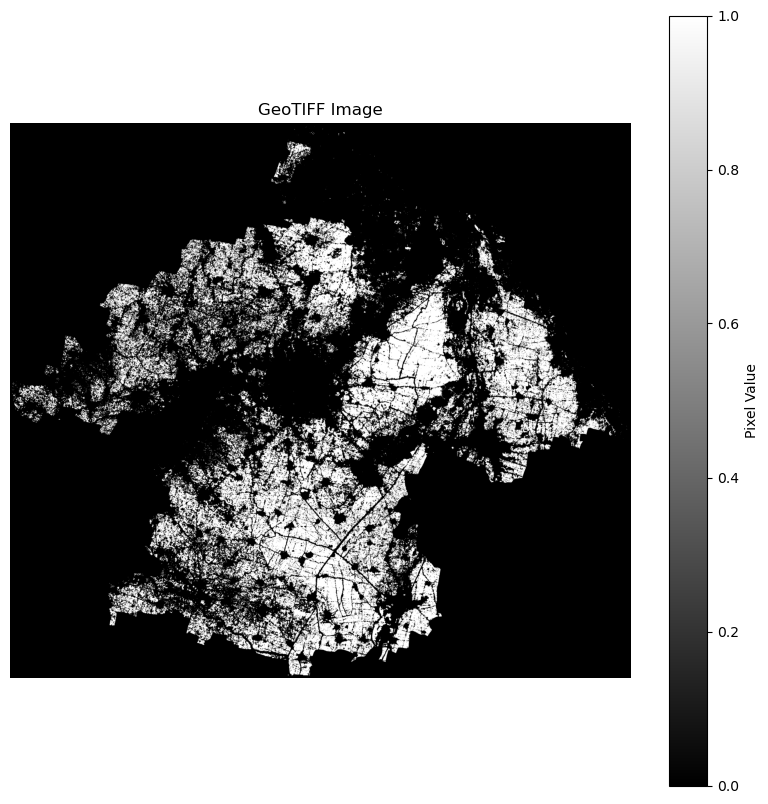

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

# Path to the GeoTIFF file
PATH = 'pred_gnt_bestthr_2023_mask.tif'

# Open the TIFF file using GDAL
dataset = gdal.Open(PATH)

# Read the raster band (assuming single-band)
band = dataset.GetRasterBand(1)
array = band.ReadAsArray()

# Print shape and dtype of the array
print(f"Array shape: {array.shape}, dtype: {array.dtype}")

# Plotting the array
plt.figure(figsize=(10, 10))
plt.imshow(array, cmap='gray',vmax=1,vmin=0)  # Change colormap as needed
plt.colorbar(label='Pixel Value')
plt.title('GeoTIFF Image')
plt.axis('off')
plt.show()
